In [29]:
import pandas as pd
import numpy as np
import re

import pickle

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay


## Load Dataset

In [2]:
data_train = pd.read_excel("Data/data_train.xlsx")
data_test = pd.read_excel("Data/data_test.xlsx")

In [3]:
X_train = data_train['Kalimat_prep']
y_train = data_train['label']

X_test = data_test['Kalimat_prep']
y_test = data_test['label']

## Baseline Classification

In [20]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))

model_svm = SVC(kernel='linear', C=1)
model_mnb = MultinomialNB()
model_lr = LogisticRegression(n_jobs=-1)

pipeline_svm = make_pipeline(tfidf_vectorizer,model_svm)
pipeline_mnb = make_pipeline(tfidf_vectorizer,model_mnb)
pipeline_lr = make_pipeline(tfidf_vectorizer,model_lr)

pipeline_svm.fit(X_train,y_train)
pipeline_mnb.fit(X_train,y_train)
pipeline_lr.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression(n_jobs=-1))])

In [21]:
print("acc SVM : ",accuracy_score(pipeline_svm.predict(X_test),y_test))
print("acc MNB : ",accuracy_score(pipeline_mnb.predict(X_test),y_test))
print("acc LR : ",accuracy_score(pipeline_lr.predict(X_test),y_test))

acc SVM :  0.9014675052410901
acc MNB :  0.8857442348008385
acc LR :  0.889937106918239


In [34]:
print("acc SVM : ", f1_score(y_test,pipeline_svm.predict(X_test),average='macro'))
print("acc MNB : ",f1_score(y_test,pipeline_mnb.predict(X_test),average='macro'))
print("acc LR : ",f1_score(y_test,pipeline_lr.predict(X_test),average='macro'))

acc SVM :  0.4537049652205296
acc MNB :  0.3131369279229201
acc LR :  0.35547964305633023


In [35]:
print(classification_report(y_test,pipeline_svm.predict(X_test)))

              precision    recall  f1-score   support

           1       0.90      1.00      0.95       845
           2       1.00      0.03      0.06        35
           3       0.81      0.23      0.36        74

    accuracy                           0.90       954
   macro avg       0.90      0.42      0.45       954
weighted avg       0.90      0.90      0.87       954



In [36]:
print(confusion_matrix(y_test,pipeline_svm.predict(X_test)))

[[842   0   3]
 [ 33   1   1]
 [ 57   0  17]]


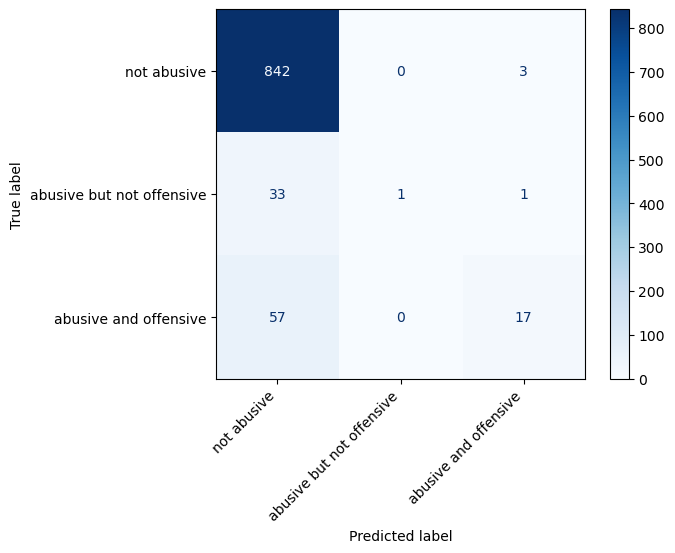

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,pipeline_svm.predict(X_test)),
                              display_labels=["not abusive","abusive but not offensive","abusive and offensive"])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.show()

## Feature Extraction Experiment

In [7]:
ngram = [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]

for i in ngram:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=i)
    model_svm = SVC(kernel='linear', C=1)

    pipeline_svm = make_pipeline(tfidf_vectorizer,model_svm)
    pipeline_svm.fit(X_train,y_train)
    
    print(f"{i} : {f1_score(y_test,pipeline_svm.predict(X_test),average='macro')}")

(1, 1) : 0.4537049652205296
(1, 2) : 0.42893535229301655
(1, 3) : 0.4110808248285787
(2, 2) : 0.3492978598828181
(2, 3) : 0.3492978598828181
(3, 3) : 0.3492978598828181


In [55]:
# HITUNG JUMLAH OOV DI SETIAP NGRAM

ngram = [(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]

for i in ngram:
    tfidf_vectorizer_train = TfidfVectorizer(ngram_range=i)
    tfidf_vectorizer_test = TfidfVectorizer(ngram_range=i)

    tfidf_vectorizer_train.fit(X_train)
    tfidf_vectorizer_test.fit(X_test)
    
    feature_train = tfidf_vectorizer_train.get_feature_names_out()
    feature_test = tfidf_vectorizer_test.get_feature_names_out()
    
    OOV = [i for i in feature_test if i not in feature_train]
    
    print(f"{i} : {len(OOV)}")

(1, 1) : 1680
(1, 2) : 13202
(1, 3) : 29158
(2, 2) : 11522
(2, 3) : 27478
(3, 3) : 15956


## Feature Selection Experiment

In [11]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer.fit(X_train)

TfidfVectorizer()

In [15]:
num_features = len(tfidf_vectorizer.get_feature_names_out())

In [17]:
num_features

6950

In [16]:
mi_selection = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in mi_selection:
    max_features = int(i*num_features)

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
    mutual_info = SelectKBest(mutual_info_classif, k=max_features)
    model_svm = SVC(kernel='linear', C=1)

    pipeline_svm = make_pipeline(tfidf_vectorizer,mutual_info,model_svm)

    pipeline_svm.fit(X_train,y_train)
    
    print(f"{i} : {f1_score(y_test,pipeline_svm.predict(X_test),average='macro')}")

0.1 : 0.44294450777108335
0.2 : 0.4366356811612286
0.3 : 0.43532359912428303
0.4 : 0.4415784712526267
0.5 : 0.4415784712526267
0.6 : 0.44770423200646015
0.7 : 0.44770423200646015
0.8 : 0.4537049652205296
0.9 : 0.44770423200646015


## Save Baseline Model

In [54]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))

pipeline_svm = make_pipeline(tfidf_vectorizer,model_svm)

pipeline_svm.fit(X_train,y_train)

print(f"maco avg f1_score : {f1_score(y_test,pipeline_svm.predict(X_test),average='macro')}")

maco avg f1_score : 0.4537049652205296


In [19]:
with open("Model/baseline_svm.pkl","wb") as f:
    pickle.dump(pipeline_svm,f)